## Deep Ensemble Code

The code in this notebook is a step‐by‐step PyTorch tutorial demonstrating how to implement deep ensemble as an ensemble method. In a deep ensemble, several independent models are trained on the same task with different random initializations. At inference time, predictions from each model are aggregated (e.g., by averaging) to obtain a final prediction and to quantify uncertainty.

### Setup and Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Define Model Architecture: a Simple Neural Network

We define a simple feed-forward network for a regression task. Each model in the ensemble will have the same architecture but will be independently initialized and trained.

In [2]:
class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


### Load the Data

In [3]:
# Create synthetic data: y = sin(2*pi*x) with added noise
np.random.seed(0)
x = np.linspace(0, 1, 100)[:, None]
y = np.sin(2 * np.pi * x) + 0.1 * np.random.randn(*x.shape)

# Convert numpy arrays to PyTorch tensors
x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()


### Train an Ensemble of Models
Here we create and train several independent models. Each model is trained on the same data, but with different initial weights.

In [4]:
def train_model(model, x, y, num_epochs=500, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        predictions = model(x)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
    return model

# Ensemble hyperparameters
ensemble_size = 5
input_dim = 1
hidden_dim = 64
output_dim = 1
num_epochs = 500
learning_rate = 0.01

# Train ensemble of models
ensemble_models = []
for i in range(ensemble_size):
    model = SimpleNet(input_dim, hidden_dim, output_dim)
    print(f"Training model {i+1}/{ensemble_size}...")
    model = train_model(model, x_tensor, y_tensor, num_epochs, learning_rate)
    ensemble_models.append(model)

Training model 1/5...
Training model 2/5...
Training model 3/5...
Training model 4/5...
Training model 5/5...


### Inference with Deep Ensembles

During inference, each model in the ensemble produces its own prediction. The final prediction is obtained by averaging the predictions, and the variability across predictions provides a measure of uncertainty.

In [5]:
def ensemble_predict(models, x):
    preds = []
    for model in models:
        model.eval()  # Set each model to evaluation mode
        with torch.no_grad():
            pred = model(x)
            preds.append(pred.cpu().numpy())
    preds = np.array(preds)  # Shape: (ensemble_size, batch_size, output_dim)
    return preds

# Get ensemble predictions
ensemble_preds = ensemble_predict(ensemble_models, x_tensor)

# Compute mean and standard deviation across the ensemble
pred_mean = ensemble_preds.mean(axis=0).squeeze()  # (batch_size,)
pred_std = ensemble_preds.std(axis=0).squeeze()


### Visualize the Results
Finally, we plot the ensemble’s mean prediction along with uncertainty bands (e.g., ±1 standard deviation).

Uncertainty Estimation: Here we use the mean and standard deviation of the predictions as an estimate of the prediction and its uncertainty, respectively.

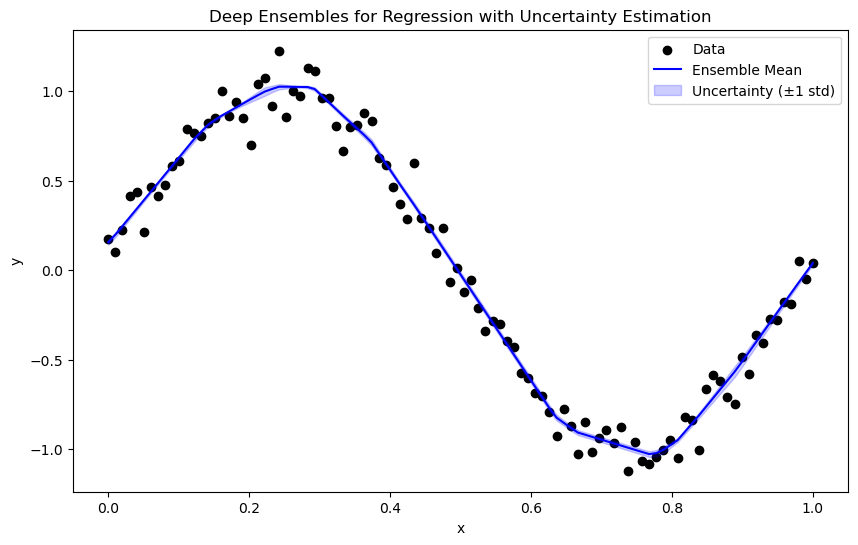

In [6]:
plt.figure(figsize=(10,6))
plt.scatter(x, y, color='black', label='Data')
plt.plot(x, pred_mean, color='blue', label='Ensemble Mean')
plt.fill_between(x.squeeze(), 
                 pred_mean - pred_std, 
                 pred_mean + pred_std, 
                 color='blue', alpha=0.2, label='Uncertainty (±1 std)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Deep Ensembles for Regression with Uncertainty Estimation')
plt.show()